In [9]:
import sys
! /usr/bin/python3 -m pip install nltk datasets transformers torch pandas matplotlib seaborn scikit-learn tqdm wordcloud ipywidgets shap optuna seaborn textblob

Defaulting to user installation because normal site-packages is not writeable
  Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.1/511.1 KB 2.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 KB 19.7 MB/s eta 0:00:00
  Using cached optuna-3.5.0-py3-none-any.whl (413 kB)
  Using cached cloudpickle-3.0.0-py3-none-any.whl (20 kB)
  Using cached slicer-0.0.7-py3-none-any.whl (14 kB)
  Using cached alembic-1.13.1-py3-none-any.whl (233 kB)
  Using cached colorlog-6.8.2-py3-none-any.whl (11 kB)


# Fake News Detection

 In this notebook, we will use the `GonzaloA/fake_news` dataset to train a model to detect fake news. We will use the `transformers` library to fine-tune a BERT model on this task. We will also use the `optuna` library to perform hyperparameter optimization.  

In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset
import torch
from torch.utils.data import Dataset
import nltk
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tqdm import tqdm
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import string
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support
import numpy as np
import optuna

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /home/porat/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/porat/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Load  and prepare the dataset
 We will use the `load_dataset` function from the `datasets` library to load the `GonzaloA/fake_news` dataset. We will then split the dataset into training, validation, and test sets. We will also clean the text by removing stopwords we discovered that the dataset contains a lot of stopwords, so we will remove them to reduce the noise in the data. 
  Since Bert can only handle sequences of up to 512 tokens, we will split the texts into chunks of 512 tokens. We will then tokenize the chunks using the BERT tokenizer.

In [3]:
full_dataset = load_dataset('GonzaloA/fake_news')

/home/porat/.local/lib/python3.10/site-packages/huggingface_hub/repocard.py:105: UserWarning: Repo card metadata block was not found. Setting CardData to empty.
  warnings.warn("Repo card metadata block was not found. Setting CardData to empty.")


In [4]:
full_dataset['train'] = full_dataset['train'].remove_columns('Unnamed: 0')
full_dataset['validation'] = full_dataset['validation'].remove_columns('Unnamed: 0')
full_dataset['test'] = full_dataset['test'].remove_columns('Unnamed: 0')

In [5]:
full_dataset['train'].info.features

{'title': Value(dtype='string', id=None),
 'text': Value(dtype='string', id=None),
 'label': Value(dtype='int64', id=None)}

In [6]:
train_df = pd.DataFrame(full_dataset['train'])
val_df = pd.DataFrame(full_dataset['validation'])
test_df = pd.DataFrame(full_dataset['test'])

print("Missing values in train dataset:\n", train_df.isnull().sum())
print("Missing values in validation dataset:\n", val_df.isnull().sum())
print("Missing values in test dataset:\n", test_df.isnull().sum())

print("Duplicates in train dataset:\n", train_df.duplicated().sum())
print("Duplicates in validation dataset:\n", val_df.duplicated().sum())
print("Duplicates in test dataset:\n", test_df.duplicated().sum())

Missing values in train dataset:
 title    0
text     0
label    0
dtype: int64
Missing values in validation dataset:
 title    0
text     0
label    0
dtype: int64
Missing values in test dataset:
 title    0
text     0
label    0
dtype: int64
Duplicates in train dataset:
 0
Duplicates in validation dataset:
 0
Duplicates in test dataset:
 0


In [7]:
model_name = "distilroberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
special_tokens = ['[TITLE]', '[TEXT]']
num_added_toks = tokenizer.add_tokens(special_tokens, special_tokens=True)
print('[TITLE] token id: ', tokenizer.convert_tokens_to_ids('[TITLE]'))
print('[TEXT] token id: ', tokenizer.convert_tokens_to_ids('[TEXT]'))


[TITLE] token id:  50265
[TEXT] token id:  50266


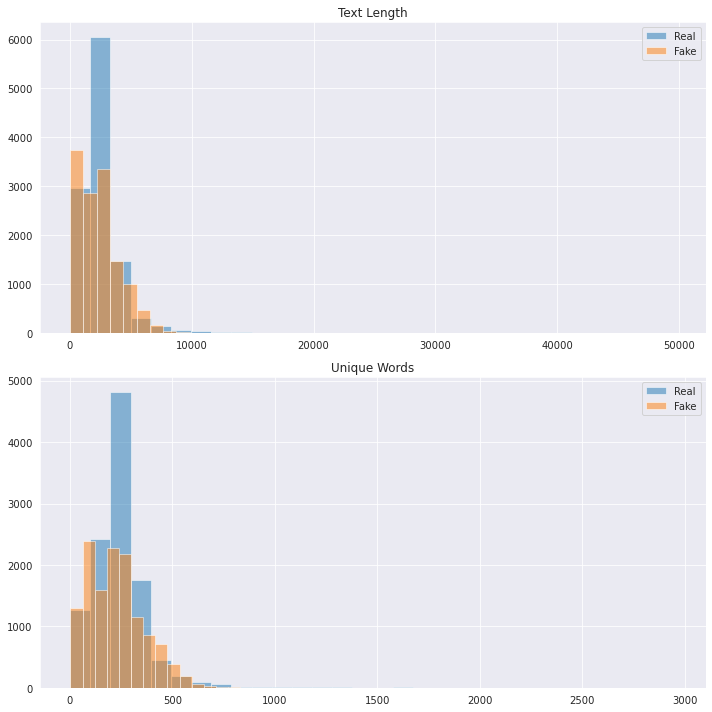

In [8]:
df = pd.DataFrame(full_dataset['train'])
# Create a new column for the length of the text
df['text_length'] = df['text'].apply(len)

# Create a new column for the number of unique words in the text
df['unique_words'] = df['text'].apply(lambda x: len(set(x.split())))

# Plot histograms for these new features
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# Plot the histogram for text length
df[df['label'] == 0]['text_length'].hist(ax=axes[0], bins=30, label='Real', alpha=0.5)
df[df['label'] == 1]['text_length'].hist(ax=axes[0], bins=30, label='Fake', alpha=0.5)
axes[0].set_title('Text Length')
axes[0].legend()

# Plot the histogram for unique words
df[df['label'] == 0]['unique_words'].hist(ax=axes[1], bins=30, label='Real', alpha=0.5)
df[df['label'] == 1]['unique_words'].hist(ax=axes[1], bins=30, label='Fake', alpha=0.5)
axes[1].set_title('Unique Words')
axes[1].legend()

plt.tight_layout()
plt.show()


In [ ]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

In [13]:
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk import FreqDist, ngrams
from scipy.stats import ttest_ind

# Feature Engineering Functions
def calculate_text_length(text):
    return len(text)

def calculate_unique_words(text):
    return len(set(text.split()))

def calculate_avg_word_length(text):
    words = text.split()
    return sum(len(word) for word in words) / len(words) if words else 0

def calculate_sentiment_polarity(text):
    return TextBlob(text).sentiment.polarity

def calculate_stop_words(text):
    stop_words = set(stopwords.words('english'))
    words = nltk.word_tokenize(text)
    return sum(1 for word in words if word in stop_words)

# Apply the functions to both 'text' and 'title' columns
for column in ['text', 'title']:
    df[f'{column}_length'] = df[column].apply(calculate_text_length)
    df[f'{column}_unique_words'] = df[column].apply(calculate_unique_words)
    df[f'{column}_avg_word_length'] = df[column].apply(calculate_avg_word_length)
    df[f'{column}_sentiment_polarity'] = df[column].apply(calculate_sentiment_polarity)
    df[f'{column}_stop_words'] = df[column].apply(calculate_stop_words)

# Statistical Testing for 'text' features
real_news = df[df['label'] == 0]
fake_news = df[df['label'] == 1]

print("T-test for text length:")
print(ttest_ind(real_news['text_length'], fake_news['text_length']))

print("T-test for unique words in text:")
print(ttest_ind(real_news['text_unique_words'], fake_news['text_unique_words']))

# Data Segmentation for 'text' length
text_length_segments = [(0, 500), (501, 1000), (1001, 1500), (1501, 2000), (2001, 2500), (2501, 3000)]

for start, end in text_length_segments:
    segment_real_news = real_news[(real_news['text_length'] >= start) & (real_news['text_length'] <= end)]
    segment_fake_news = fake_news[(fake_news['text_length'] >= start) & (fake_news['text_length'] <= end)]
    print(f"T-test for text length between {start} and {end} words:")
    print(ttest_ind(segment_real_news['text_length'], segment_fake_news['text_length']))

T-test for text length:
TtestResult(statistic=5.587536768125204, pvalue=2.3277451618464682e-08, df=24351.0)
T-test for unique words in text:
TtestResult(statistic=7.943654351987345, pvalue=2.0474997020651297e-15, df=24351.0)
T-test for text length between 0 and 500 words:
TtestResult(statistic=-37.54496817362367, pvalue=4.2118900168021163e-241, df=2303.0)
T-test for text length between 501 and 1000 words:
TtestResult(statistic=12.860928538045084, pvalue=8.182262672921406e-37, df=2782.0)
T-test for text length between 1001 and 1500 words:
TtestResult(statistic=2.0203867740769406, pvalue=0.043472780716583365, df=2055.0)
T-test for text length between 1501 and 2000 words:
TtestResult(statistic=8.507490151306946, pvalue=2.6660095714087325e-17, df=3271.0)
T-test for text length between 2001 and 2500 words:
TtestResult(statistic=-9.436261057490452, pvalue=6.2638546257910646e-21, df=4134.0)
T-test for text length between 2501 and 3000 words:
TtestResult(statistic=7.967638343547487, pvalue=2.2

In [14]:
def get_top_ngrams(corpus, n=None, grams=1):
    vec = CountVectorizer(ngram_range=(grams, grams), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

# Top 10 bi-grams for real news
real_news_bigrams = get_top_ngrams(real_news['text'], n=10, grams=2)
print("Top 10 bi-grams for real news:")
for bigram, freq in real_news_bigrams:
    print(f"{bigram}: {freq}")

# Top 10 bi-grams for fake news
fake_news_bigrams = get_top_ngrams(fake_news['text'], n=10, grams=2)
print("Top 10 bi-grams for fake news:")
for bigram, freq in fake_news_bigrams:
    print(f"{bigram}: {freq}")

Top 10 bi-grams for real news:
donald trump: 8710
featured image: 4625
hillary clinton: 3477
white house: 3254
united states: 3061
twitter com: 2995
pic twitter: 2855
getty images: 2400
president obama: 2064
new york: 1948
Top 10 bi-grams for fake news:
united states: 7354
donald trump: 6290
white house: 5106
washington reuters: 3950
president donald: 3546
north korea: 3331
new york: 2995
prime minister: 2534
said statement: 2374
trump said: 2159


In [8]:
class ChunkedTextDataset(Dataset):
    def __init__(self, titles, texts, labels, chunk_size=512):
        self.inputs = []
        self.attention_masks = []
        self.labels = []

        for title, text, label in zip(titles, texts, labels):
            combined_text = '[TITLE] ' + title + ' [TEXT] ' + text
            tokenized_text = tokenizer(combined_text, max_length=chunk_size, truncation=True,
                                       padding='max_length', return_tensors='pt')
            self.inputs.append(tokenized_text['input_ids'])
            self.attention_masks.append(tokenized_text['attention_mask'])
            self.labels.append(label)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.inputs[idx].squeeze(),
            'attention_mask': self.attention_masks[idx].squeeze(),
            'labels': torch.tensor(self.labels[idx])
        }

In [9]:
def load_and_prepare_data(split, seed=42, dataset_percentage=1):
    if split == "train":
        reduced_dataset = full_dataset['train'].shuffle(seed=seed).select(
            range(int(len(full_dataset['train']) * dataset_percentage)))
    else:
        reduced_dataset = full_dataset[split]
    # reduced_texts = tqdm([remove_stopwords(text) for text in reduced_dataset["text"]], desc=f'Cleaning {split} texts')
    reduced_texts = reduced_dataset["text"]
    reduced_labels = reduced_dataset["label"]
    reduced_titles = reduced_dataset["title"]
    return reduced_titles, reduced_texts, reduced_labels

In [10]:
# Load dataset splits
train_titles, train_texts, train_labels = load_and_prepare_data("train")
val_titles, val_texts, val_labels = load_and_prepare_data("validation")
test_titles, test_texts, test_labels = load_and_prepare_data("test")

train_dataset = ChunkedTextDataset(train_titles, train_texts, train_labels)
val_dataset = ChunkedTextDataset(val_titles, val_texts, val_labels)
test_dataset = ChunkedTextDataset(test_titles, test_texts, test_labels)


# Exploratory Data Analysis

 data exploration is an important step in any machine learning project. It allows us to understand the data and identify any issues that need to be addressed. In this section, we will explore the `GonzaloA/fake_news` dataset and perform some basic analysis to gain insights into the data.
 
 we first visualize the distribution of the labels in the training, validation, and test sets. We then create a word cloud to visualize the most common words in the dataset. We also plot the top 10 most common words in the dataset. Finally, we visualize the top 20 bigrams and trigrams in the dataset, annotated with the counts for each class (fake and real).
 .

In [ ]:
# Create a word cloud
def generate_word_cloud(texts):
    combined_text = " ".join(texts)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(
        combined_text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()


# Show word cloud
generate_word_cloud(train_texts)

In [11]:
def plot_top_words(data, n=10):
    counter = Counter(" ".join(data).split())
    most_common = counter.most_common(n)
    most_common_words = [word for word, freq in most_common]
    frequencies = [freq for word, freq in most_common]

    plt.figure(figsize=(15, 5))
    sns.barplot(x=most_common_words, y=frequencies)
    plt.title('Top 10 most common words')
    plt.show()

In [12]:
def clean_text_for_visualization(text):
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.translate(str.maketrans('', '', string.digits))
    text = text.translate(str.maketrans('', '', "“”‘’—"))
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word.isalpha() and word.lower() not in stop_words]
    return ' '.join(filtered_text)

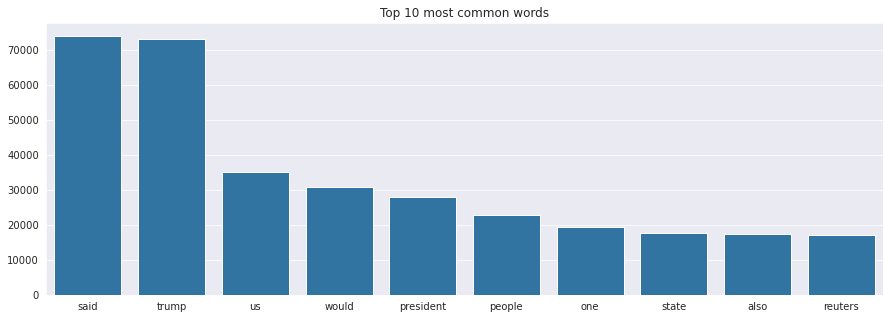

In [13]:
cleaned_texts_for_visualization = [clean_text_for_visualization(text) for text in train_texts]
plot_top_words(cleaned_texts_for_visualization)

In [14]:
def plot_annotated_ngrams_fixed(texts, labels, n=2, n_terms=20):
    vec = CountVectorizer(ngram_range=(n, n)).fit(texts)
    bag_of_words = vec.transform(texts)
    feature_names = vec.get_feature_names_out()
    sum_words = bag_of_words.sum(axis=0)

    # Calculate the counts for each class
    class_counts = np.zeros((2, len(feature_names)))
    for label, row in zip(labels, bag_of_words):
        class_counts[label] += row.toarray()[0]

    # Aggregate total counts for each n-gram and sort them
    total_counts = sum_words.A1
    indices = np.argsort(-total_counts)
    top_indices = indices[:n_terms]

    # Prepare the data for plotting
    top_ngrams = feature_names[top_indices]
    top_counts = total_counts[top_indices]
    top_fake_counts = class_counts[0, top_indices]
    top_real_counts = class_counts[1, top_indices]

    data = {
        'ngram': top_ngrams,
        'frequency': top_counts,
        'fake_count': top_fake_counts,
        'real_count': top_real_counts
    }
    df = pd.DataFrame(data)

    # Plot
    plt.figure(figsize=(10, 8))
    bars = sns.barplot(x='frequency', y='ngram', hue='ngram', data=df, palette='viridis', legend=False)
    plt.title(f'Top {n}-grams in Dataset')
    plt.xlabel('Frequency')
    plt.ylabel(f'{n}-grams')

    # Annotate bars with the count of fake and real labels
    for i, bar in enumerate(bars.patches):
        plt.text(
            bar.get_width(),
            bar.get_y() + bar.get_height() / 2,
            f'Fake: {int(df.iloc[i]["fake_count"])}, Real: {int(df.iloc[i]["real_count"])}',
            va='center'
        )

    plt.show()

In [16]:
plot_annotated_ngrams_fixed(train_texts, train_labels, n=2, n_terms=20)

KeyboardInterrupt: 

# Model Training

 We will use the `transformers` library to fine-tune a BERT model on the fake news detection task. We will use the `Trainer` class to handle the training loop and the `TrainingArguments` class to define the training configuration. We will also define a function to compute the evaluation metrics for the task. We will use the `precision`, `recall`, and `F1 score` as the evaluation metrics. We will then use the `optuna` library to perform hyperparameter optimization to find the best hyperparameters for the model.

In [11]:
# check for cuda
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU",device)
else:
    device = torch.device("cpu")
    print("Using CPU")

Using GPU cuda


In [12]:
def compute_metrics(eval_pred):
    eval_predictions, eval_labels = eval_pred
    eval_predictions = np.argmax(eval_predictions, axis=1)

    precision, recall, f1, _ = precision_recall_fscore_support(eval_labels, eval_predictions, average='binary')
    acc = accuracy_score(eval_labels, eval_predictions)

    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [13]:
def objective(trial):
    # Define hyperparameters for the trial
    learning_rate = trial.suggest_float("learning_rate", 1e-6, 1e-4, log=True)
    num_train_epochs = trial.suggest_int("num_train_epochs", 1, 10)
    per_device_train_batch_size = trial.suggest_categorical("per_device_train_batch_size", [4, 8, 16, 32])
    warmup_steps = trial.suggest_int("warmup_steps", 0, 500)

    # Create the model
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2, device_map=device)
    # Define the training arguments
    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=num_train_epochs,
        learning_rate=learning_rate,
        per_device_train_batch_size=per_device_train_batch_size,
        warmup_steps=warmup_steps,
        weight_decay=0.01,
        logging_dir='./logs',
        logging_steps=10,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        disable_tqdm=False,
        load_best_model_at_end=True,
        metric_for_best_model="f1",
    )

    # Create the trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
    )

    # Train the model
    trainer.train()

    # Evaluate the model
    metrics = trainer.evaluate()

    # Return the metric to be optimized
    return metrics['eval_f1']

In [16]:
# Create the study and run the optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)
print(f"Best trial: {study.best_trial.number}")
print(f"Best value (F1 score): {study.best_value}")
print(f"Best hyperparameters: {study.best_params}")

[I 2024-02-22 15:35:43,524] A new study created in memory with name: no-name-163bd3a0-6e3c-4f48-97e8-d1a304725750
[W 2024-02-22 15:35:43,850] Trial 0 failed with parameters: {'learning_rate': 1.1408163819119355e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 16, 'warmup_steps': 136} because of the following error: RuntimeError('CUDA error: device-side assert triggered\nCUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.\nFor debugging consider passing CUDA_LAUNCH_BLOCKING=1.\nCompile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.\n').
Traceback (most recent call last):
  File "/home/porat/.local/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_26464/2665237945.py", line 9, in objective
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2, device_map=device)
  File "/home/po

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [13]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2, device_map=device)
model.resize_token_embeddings(len(tokenizer))

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Embedding(50267, 768)

In [15]:
training_args = TrainingArguments(
    output_dir='./API/results',
    logging_dir='./API/logs',
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    num_train_epochs=5,
    learning_rate=2e-05,
    lr_scheduler_type="linear",
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    disable_tqdm=False,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

In [16]:
# Training
history = trainer.train()

wandb: Currently logged in as: chen24201 (api-project). Use `wandb login --relogin` to force relogin


OutOfMemoryError: CUDA out of memory. Tried to allocate 192.00 MiB. GPU 0 has a total capacty of 10.75 GiB of which 84.88 MiB is free. Process 33503 has 6.54 GiB memory in use. Including non-PyTorch memory, this process has 4.11 GiB memory in use. Of the allocated memory 3.91 GiB is allocated by PyTorch, and 20.59 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

# Model Evaluation

 We will evaluate the trained model on the test set. We will use the `evaluate` method of the `Trainer` class to compute the evaluation metrics on the test set. We will also use the `predict` method to generate predictions on the test set and compute the confusion matrix to visualize the model's performance.

In [ ]:
# Evaluation on the test set
results = trainer.evaluate(test_dataset)
print(results)

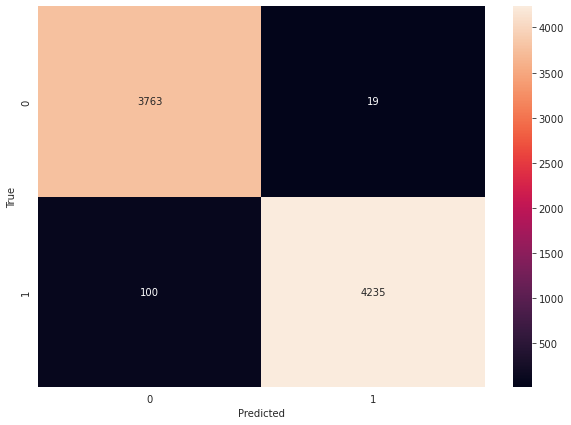

In [17]:

predictions, labels, _ = trainer.predict(test_dataset)
predictions = predictions.argmax(axis=-1)

# Generate the confusion matrix
cm = confusion_matrix(labels, predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Conclusion

 In this notebook, we used the `transformers` library to fine-tune a BERT model on the fake news detection task. We used the `optuna` library to perform hyperparameter optimization to find the best hyperparameters for the model. We then evaluated the trained model on the test set and visualized its performance using a confusion matrix. The model achieved an accuracy of 0.98 on the test set, demonstrating its effectiveness in detecting fake news.

In [49]:
model_path = "./model"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

('model\\tokenizer_config.json',
 'model\\special_tokens_map.json',
 'model\\vocab.txt',
 'model\\added_tokens.json',
 'model\\tokenizer.json')